# WiDS 2023 - Codeup Submission
## Predict the arithmetic mean of the max and min observed temperature over the next 14 days for specific locations and start dates

## Project Description
Extreme weather events are sweeping the globe and range from heat waves, wildfires and drought to hurricanes, extreme rainfall and flooding. These weather events have multiple impacts on agriculture, energy, transportation, as well as low resource communities and disaster planning in countries across the globe.

Accurate long-term forecasts of temperature and precipitation are crucial to help people prepare and adapt to these extreme weather events. Currently, purely physics-based models dominate short-term weather forecasting. But these models have a limited forecast horizon. The availability of meteorological data offers an opportunity for data scientists to improve sub-seasonal forecasts by blending physics-based forecasts with machine learning. Sub-seasonal forecasts for weather and climate conditions (lead-times ranging from 15 to more than 45 days) would help communities and industries adapt to the challenges brought on by climate change.

Participants will submit forecasts of temperature and precipitation for one year, competing against the other teams as well as official forecasts from NOAA.

## Project Goals
* Determine which columns to use for our data exploration.
* Explore to find features that indicate the ```contest-tmp2m-14d__tmp2m```.
* Based on the findings predict the ```contest-tmp2m-14d__tmp2m``` for the test_data.
* Submit our finidings to the WiDS 2023 competition.

# Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
import sklearn.preprocessing as pre
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings("ignore")

from scipy import stats
import re

import wrangle1 as w
import explore1 as e
import model as m

# Acquire

* Data acquired from [Kaggle](https://www.kaggle.com/competitions/widsdatathon2023/data)
* It contained 375734 rows and 245 columns before cleaning
* Each row represents a specific location on a specific start date
* Each column represents a weather/climate measurement

# Prepare

**Prepare Actions:**
* Binned regions (Dry, Temperate, Continental) 
* Binned elevation ('bottom_low', 'top_low', 'mid', 'high')
* Split data into train, validate and test (approx. 60/25/15)
* Scaled continuous variables (min/max scaler)
* Outliers have not been removed for this iteration of the project

## Data Dictionary:
### Target
| Target | Definition | Data Type | Unit |
| :---- | :---- | :---- | :---- |
| **mean_temp**| the arithmetic mean | *float64* | celsius |

### Features

| Feature Name | Definition | Data Type | Unit |
| :---- | :---- | :---- | :---- |
| region | Köppen-Geigerclimateclassifications | object | specified regions |
| elevation | elevation | int64 | meters |
| lat| latitude of location (anonymized) | float64 | latitude |
| lon | longitude of location (anonymized) | float64 | longitude |
| startdate | startdate of the 14 day period | object | dates |
| potential_evap| potential evaporation | float64 | mL |
| precip| measured precipitation | float64 | mm |
| barometric_pressure | pressure | float64 |Hg (inches of mercury) |
| all_atmos_precip | precipitable water for entire atmosphere | float64 | mm |
| relative humidity | relative humidity | float64 | percent of atmospheric capacity |
| sea level pressure | sea level pressure at surface | float64 | hectoPascals (hPa), also called millibars |
| geopotential height at 10 millibars | actual height of a pressure surface above mean sea-level | float64 | millibars |
| geopotential height at 100 millibars | actual height of a pressure surface above mean sea-level | float64 | millibars |
| geopotential height at 500 millibars | actual height of a pressure surface above mean sea-level | float64 | millibars |
| geopotential height at 850 millibars | actual height of a pressure surface above mean sea-level | float64 | millibars |
| zonal wind at 250 millibars | east-west wind velocity| float64 | meters per second |
| zonal wind at 925 millibars | east-west wind velocity | float64 | meters per second|
| longitudinal wind at 250 millibars | north-south velocity | float64 | meters per second|
| longitudinal wind at 925 millibars | north-south velocity | float64 |meters per second |

In [2]:
# acquiring data
df = w.get_explore_data()

# prepping data
df = w.get_contest_data(df)

# splitting data into train, validate, and test
train, validate, test = w.split_data(df)

## A brief look at the data

In [3]:
train.head()

,region,elevation,lat,lon,startdate,potential_evap,precip,barometric_pressure,all_atmos_precip,relative_humidity,...,height_10_mb,height_100_mb,height_500_mb,height_850_mb,zonal_wind_250mb,zonal_wind_925mb,long_wind_250mb,long_wind_925mb,elevation_range,region_bins
116277,BSk,1800.0,0.454545,0.300000,2014-10-19,294.86,0.03,83362.52,8.53,28.94,...,30825.95,16475.47,5796.30,1504.26,18.22,-0.87,3.46,2.04,high,Dry
237629,Csb,1100.0,0.727273,0.066667,2014-10-25,127.70,63.74,89156.29,16.71,83.14,...,30801.60,16340.47,5689.14,1504.33,24.22,1.52,1.08,3.10,mid,Temperate
272599,BSk,800.0,0.772727,0.700000,2016-06-29,481.48,41.43,89665.38,22.36,54.72,...,31605.85,16624.04,5828.97,1492.70,23.68,-0.08,2.35,1.04,top_low,Dry
205713,Dfb,2000.0,0.636364,0.500000,2015-06-30,453.35,24.78,77957.43,17.11,47.80,...,31576.02,16662.35,5875.87,1505.58,15.35,0.50,5.52,1.09,high,Continental
120041,BSk,1900.0,0.454545,0.466667,2015-02-05,135.47,0.00,81613.28,6.06,62.50,...,30715.39,16357.43,5755.62,1535.91,19.55,0.42,-10.67,0.27,high,Dry


In [4]:
train.shape

(244226, 22)

# Explore

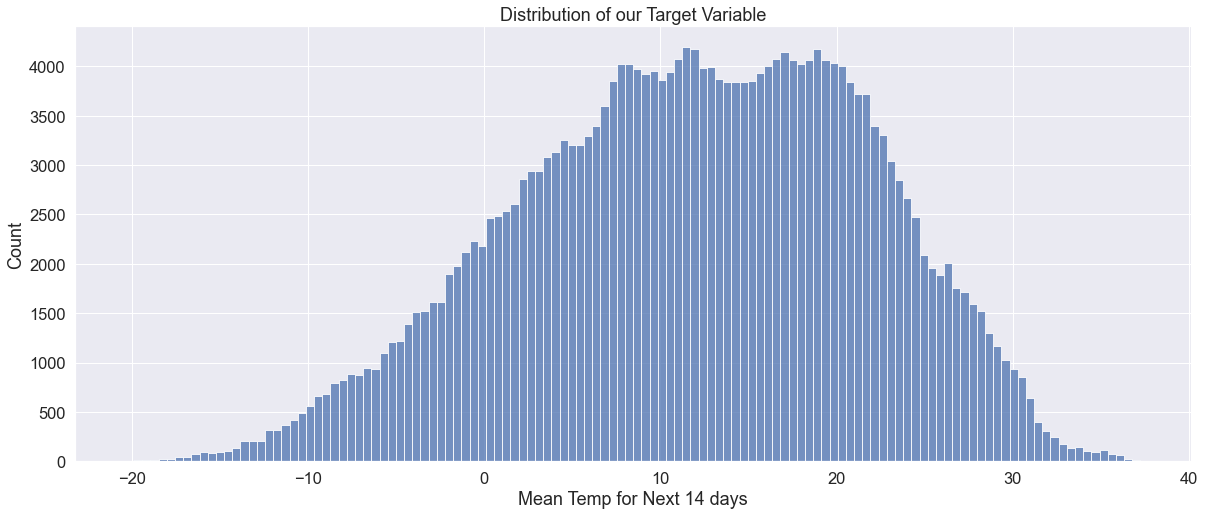

In [5]:
e.data_distribution(train)

## Is there a difference in the temperatures in different climateregions?

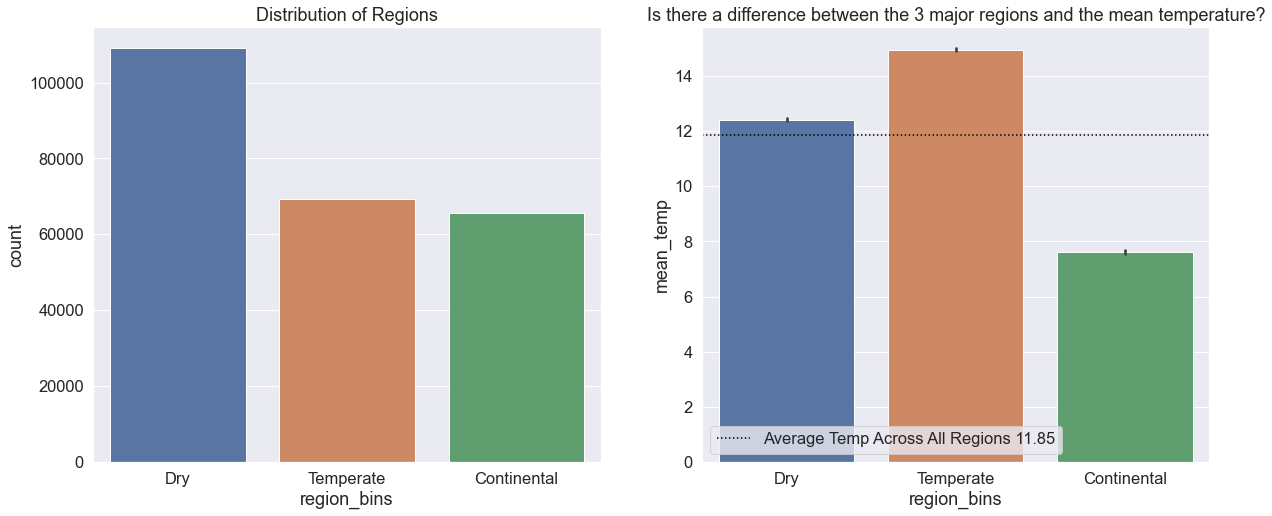

In [6]:
e.region_viz(train)

We should bin these based on first letter of region and run Kruskall-Wallis.

In [7]:
e.region_bin_stats_test(train)

p-value: 0.0


## Does elevation impact temperature?

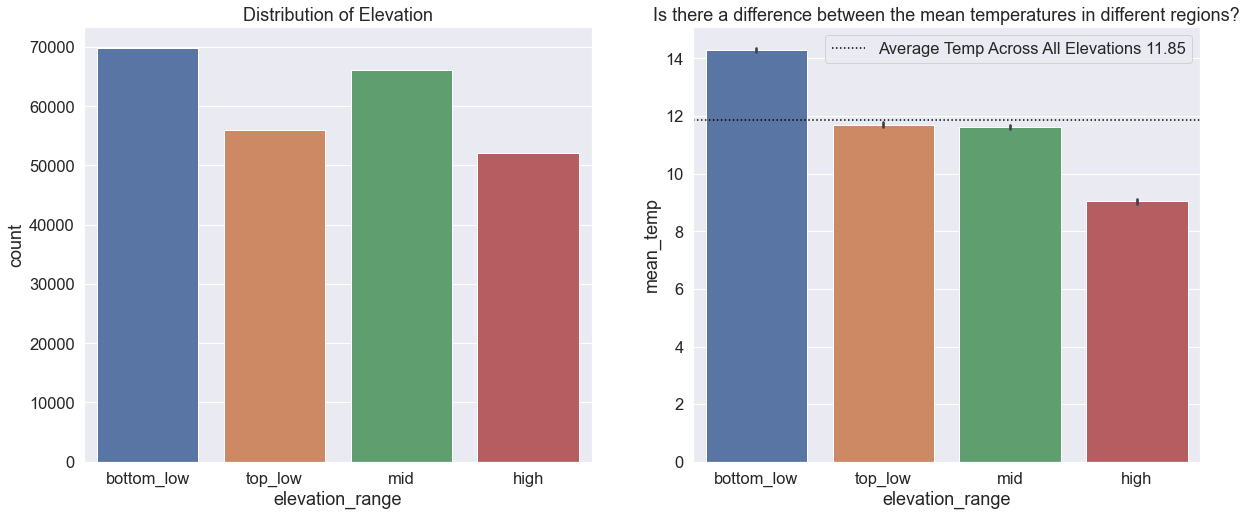

In [8]:
e.elevation_bin_viz(train)

In [9]:
e.elevation_bin_stats_test(train)

p-value: 0.0


## Is there a correlation between precipitation and mean_temp?

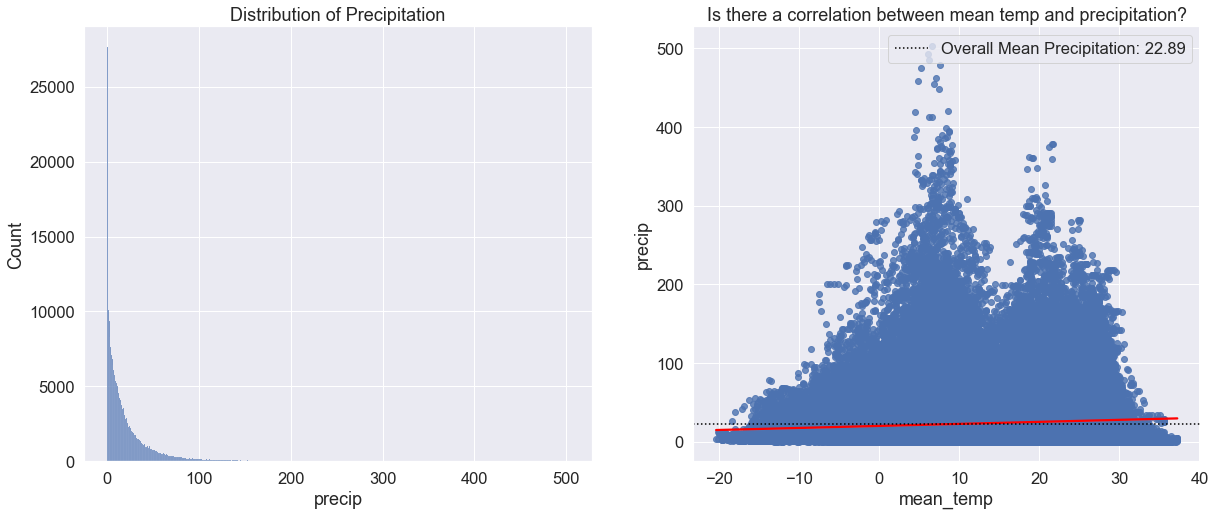

In [10]:
e.precipitation_viz(train)

In [11]:
e.precip_stats_test(train)

p-value: 6.737735320241618e-222


Distribution is skewed. We will not put this in our model.

## Is there a correlation between potential evap and mean_temp?

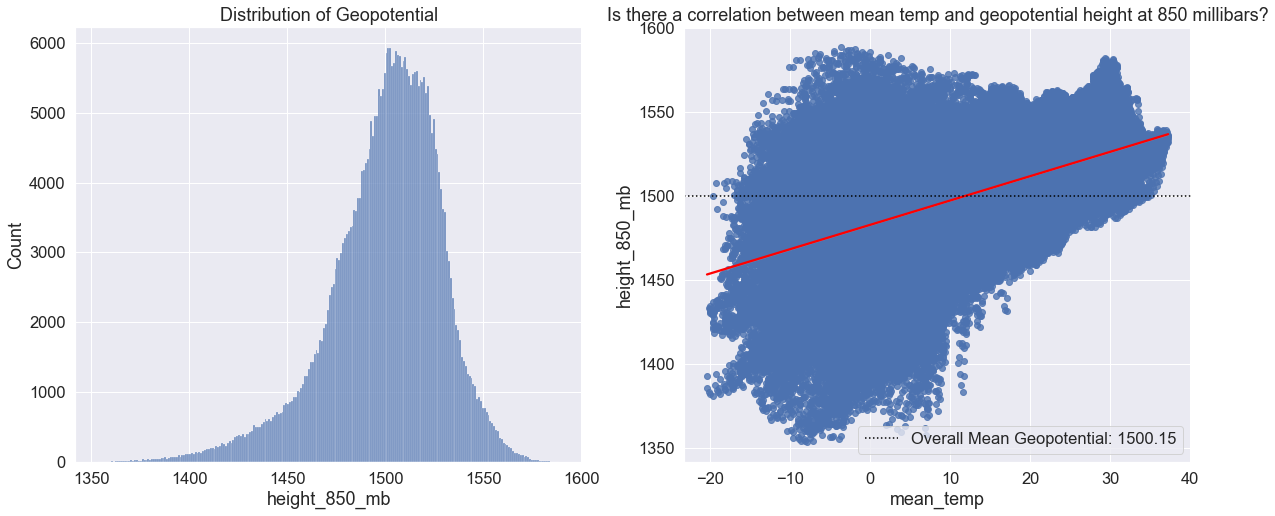

In [108]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

sns.histplot(data=df, x ='height_850_mb', ax=ax[0])
ax[0].set_title('Distribution of Geopotential')

sns.regplot(x='mean_temp', y='height_850_mb', data=df, line_kws={'color': 'red'}, ax=ax[1])
ax[1].set_title('Is there a correlation between mean temp and geopotential height at 850 millibars?')
rate = df['height_850_mb'].mean()
ax[1].axhline(rate,  label = f'Overall Mean Geopotential: {rate:.2f}', linestyle='dotted', color='black')
ax[1].legend()
plt.show()

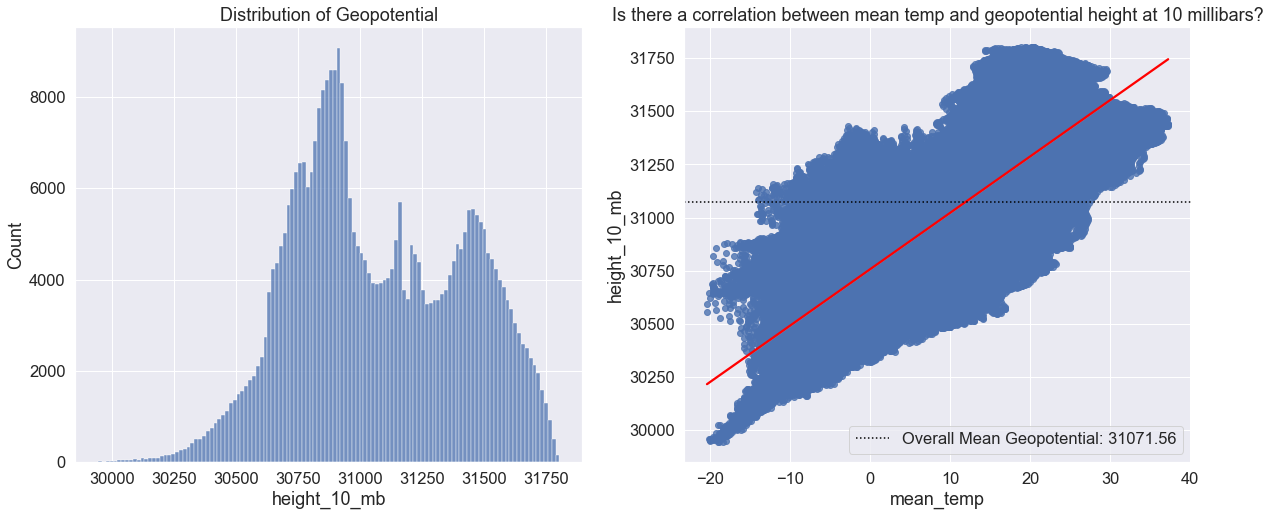

In [109]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

sns.histplot(data=df, x ='height_10_mb', ax=ax[0])
ax[0].set_title('Distribution of Geopotential')

sns.regplot(x='mean_temp', y='height_10_mb', data=df, line_kws={'color': 'red'}, ax=ax[1])
ax[1].set_title('Is there a correlation between mean temp and geopotential height at 10 millibars?')
rate = df['height_10_mb'].mean()
ax[1].axhline(rate,  label = f'Overall Mean Geopotential: {rate:.2f}', linestyle='dotted', color='black')
ax[1].legend()
plt.show()

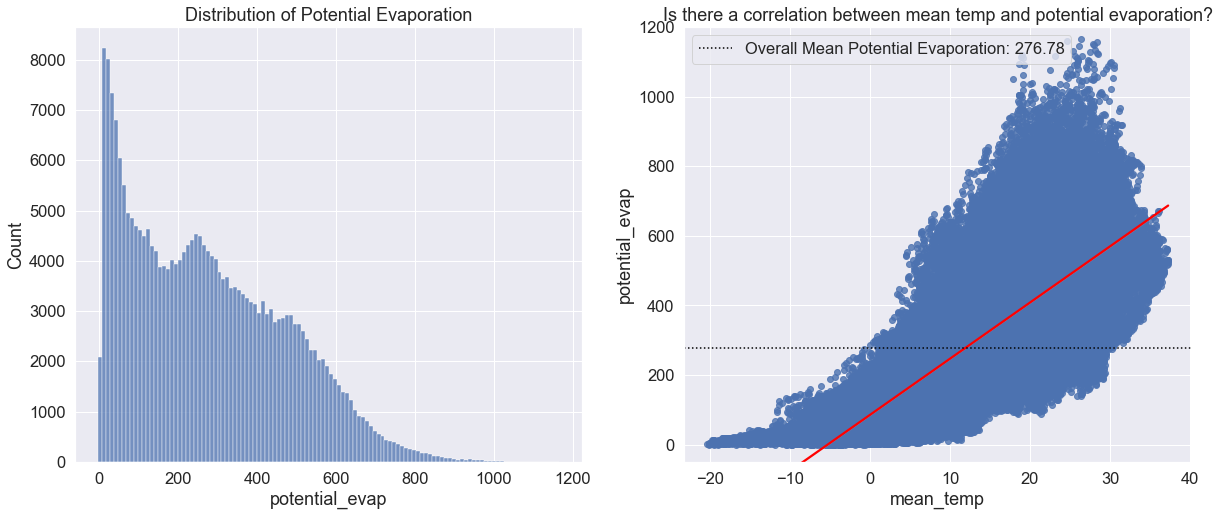

In [12]:
e.potential_evap_viz(train)

In [13]:
e.potential_evap_stats_test(train)

p-value: 0.0


There is a linear correlation so we will take this to the model.

# Exploration Summary

* ?????

# Features I am moving to modeling With
| Feature | Reason | 
|:--------|:-----------|
|**region**| $Kruskall Wallis$ results|
|**elevation**| $Kruskall Wallis$ test results|
|**????**| $chi^2$ test results|

| Feature Name | Definition | Data Type | Unit |
| :---- | :---- | :---- | :---- |
| region | Köppen-Geigerclimateclassifications | object | specified regions |
| elevation | elevation | int64 | meters |
| lat| latitude of location (anonymized) | float64 | latitude |
| lon | longitude of location (anonymized) | float64 | longitude |
| startdate | startdate of the 14 day period | object | dates |
| potential_evap| potential evaporation | float64 | mL |
| precip| measured precipitation | float64 | mm |
| barometric_pressure | pressure | float64 |Hg (inches of mercury) |
| all_atmos_precip | precipitable water for entire atmosphere | float64 | mm |
| relative humidity | relative humidity | float64 | percent of atmospheric capacity |
| sea level pressure | sea level pressure at surface | float64 | hectoPascals (hPa), also called millibars |
| geopotential height at 10 millibars | actual height of a pressure surface above mean sea-level | float64 | millibars |
| geopotential height at 100 millibars | actual height of a pressure surface above mean sea-level | float64 | millibars |
| geopotential height at 500 millibars | actual height of a pressure surface above mean sea-level | float64 | millibars |
| geopotential height at 850 millibars | actual height of a pressure surface above mean sea-level | float64 | millibars |
| zonal wind at 250 millibars | east-west wind velocity| float64 | meters per second |
| zonal wind at 925 millibars | east-west wind velocity | float64 | meters per second|
| longitudinal wind at 250 millibars | north-south velocity | float64 | meters per second|
| longitudinal wind at 925 millibars | north-south velocity | float64 |meters per second |

# Features I'm not moving to modeling with
| Feature | Reason | 
|:--------|:-----------|
|**?????**| >>>>>|
|**?????**| >>>>>|
|**?????**| >>>>>|
|**?????**| >>>>>|

In [56]:
drivers = list(train.columns)
drivers.remove('startdate')
drivers.remove('mean_temp')

# Modeling
* 

In [58]:
# prep data for modeling
X_train, y_train, X_validate, y_validate, X_test, y_test = m.prep_for_model(train, validate, test, 'mean_temp', drivers)

In [19]:
m.baseline_models(y_train, y_validate)

,model,RMSE_train,RMSE_validate,Difference
0,mean_baseline,9.856466,9.888814,-0.032347
1,median_baseline,9.866276,9.897896,-0.031619


# Comparing Models

* ????

In [60]:
m.regression_models(X_train, y_train, X_validate, y_validate)

,model,RMSE_train,RMSE_validate
0,OLS Regressor,1.835981,1.830144
1,Lasso_alpha_1,9.856466,9.888814
2,Quadratic,1.276821,1.277780


In [92]:
regressor_weights.sort_values(by='weights', ascending=False)

,features,weights
12,height_850_mb,27.104945
11,height_500_mb,12.209547
9,height_10_mb,7.277172
5,barometric_pressure,4.705320
6,all_atmos_precip,4.401436
3,potential_evap,1.954758
18,region_BWh,1.681576
14,zonal_wind_925mb,1.663262
4,precip,1.611420
34,region_bins_Dry,1.338926


## Best Model on Test

In [105]:
m.best_model(X_train, y_train, X_validate, y_validate, X_test, y_test)

,model,RMSE_train,r^2_train,RMSE_validate,r^2_validate,RMSE_test,r^2_test
0,Quadratic,2.139117,0.952899,2.138577,0.953231,2.135173,0.953385


### Modeling Summary

* ?????

# Conclusions

### Exploration

* ????

### Modeling

* ????

### Recommendations

* ?????

### Next Steps
* ?????